# 0. Imports

## 0.1 Libraries

In [96]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

import shap

## 0.2. Model and data from part 1

In [97]:
from pickle import load
with open("../Part_1/part_1_model.pkl", "rb") as f:
    linear_reg = load(f)

df_train = pd.read_csv('../Part_1/data/processed_train_data.csv',index_col='id')
df_test = pd.read_csv('../Part_1/data/processed_test_data.csv',index_col='id')

In [98]:
df_train.head()

,model_year,milage,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,...,int_col_Brown,int_col_Ebony,int_col_Global Black,int_col_Gray,int_col_Jet Black,int_col_Orange,int_col_Red,int_col_White,int_col_other,price
id,,,,,,,,,,,,,,,,,,,,,
0,2007,213000,False,True,172.0,1.6,4.0,True,False,False,...,False,False,False,True,False,False,False,False,False,4200
1,2002,143250,True,True,252.0,3.9,8.0,True,False,False,...,False,False,False,False,False,False,False,False,False,4999
2,2002,136731,False,True,320.0,5.3,8.0,True,False,False,...,False,False,False,True,False,False,False,False,False,13900
3,2017,19500,False,True,420.0,5.0,8.0,False,False,True,...,False,False,False,False,False,False,False,False,False,45000
4,2021,7388,False,True,208.0,2.0,4.0,True,False,False,...,False,False,False,False,False,False,False,False,False,97500


In [99]:
df_test.head()

,model_year,milage,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,...,int_col_Brown,int_col_Ebony,int_col_Global Black,int_col_Gray,int_col_Jet Black,int_col_Orange,int_col_Red,int_col_White,int_col_other,price
id,,,,,,,,,,,,,,,,,,,,,
37707,2003,46200,False,True,315.0,3.6,6.0,False,True,False,...,False,False,False,False,False,False,False,False,False,28750
37708,2010,115000,False,True,148.0,2.0,4.0,False,True,False,...,False,False,False,False,False,False,False,False,False,8950
37709,2021,39700,False,True,365.0,3.3,6.0,True,False,False,...,False,False,False,False,False,False,False,False,False,44400
37710,2022,22185,False,False,343.0,5.7,6.0,True,False,False,...,False,False,False,False,False,False,False,False,False,46599
37711,2011,152000,False,False,265.0,3.5,6.0,True,False,False,...,False,False,False,False,False,False,False,False,False,50500


In [100]:
def train_score_model (df_train, df_test):
	X_train = df_train.drop(columns='price')
	y_train = df_train['price']
	X_test = df_test.drop(columns='price')
	y_test = df_test['price']
	
	linear_reg = LinearRegression()
	linear_reg.fit(X_train, y_train)
	y_pred = linear_reg.predict(X_test)
	
	r2 = r2_score(y_test, y_pred)
	
	return r2

# 1. Error Analysis

First, we wanted to confirm that the errors of our model do not result from a prr distribution od the data in the train and test sets.

The train set data is painted colored blue and the test set data is colored orange.

We can see that the distributions are quite similar, most of the graphs have a red shade - because the train and test mostly overlap.

In additon, we added a Two-Sample KS test for a quantifiable measure.

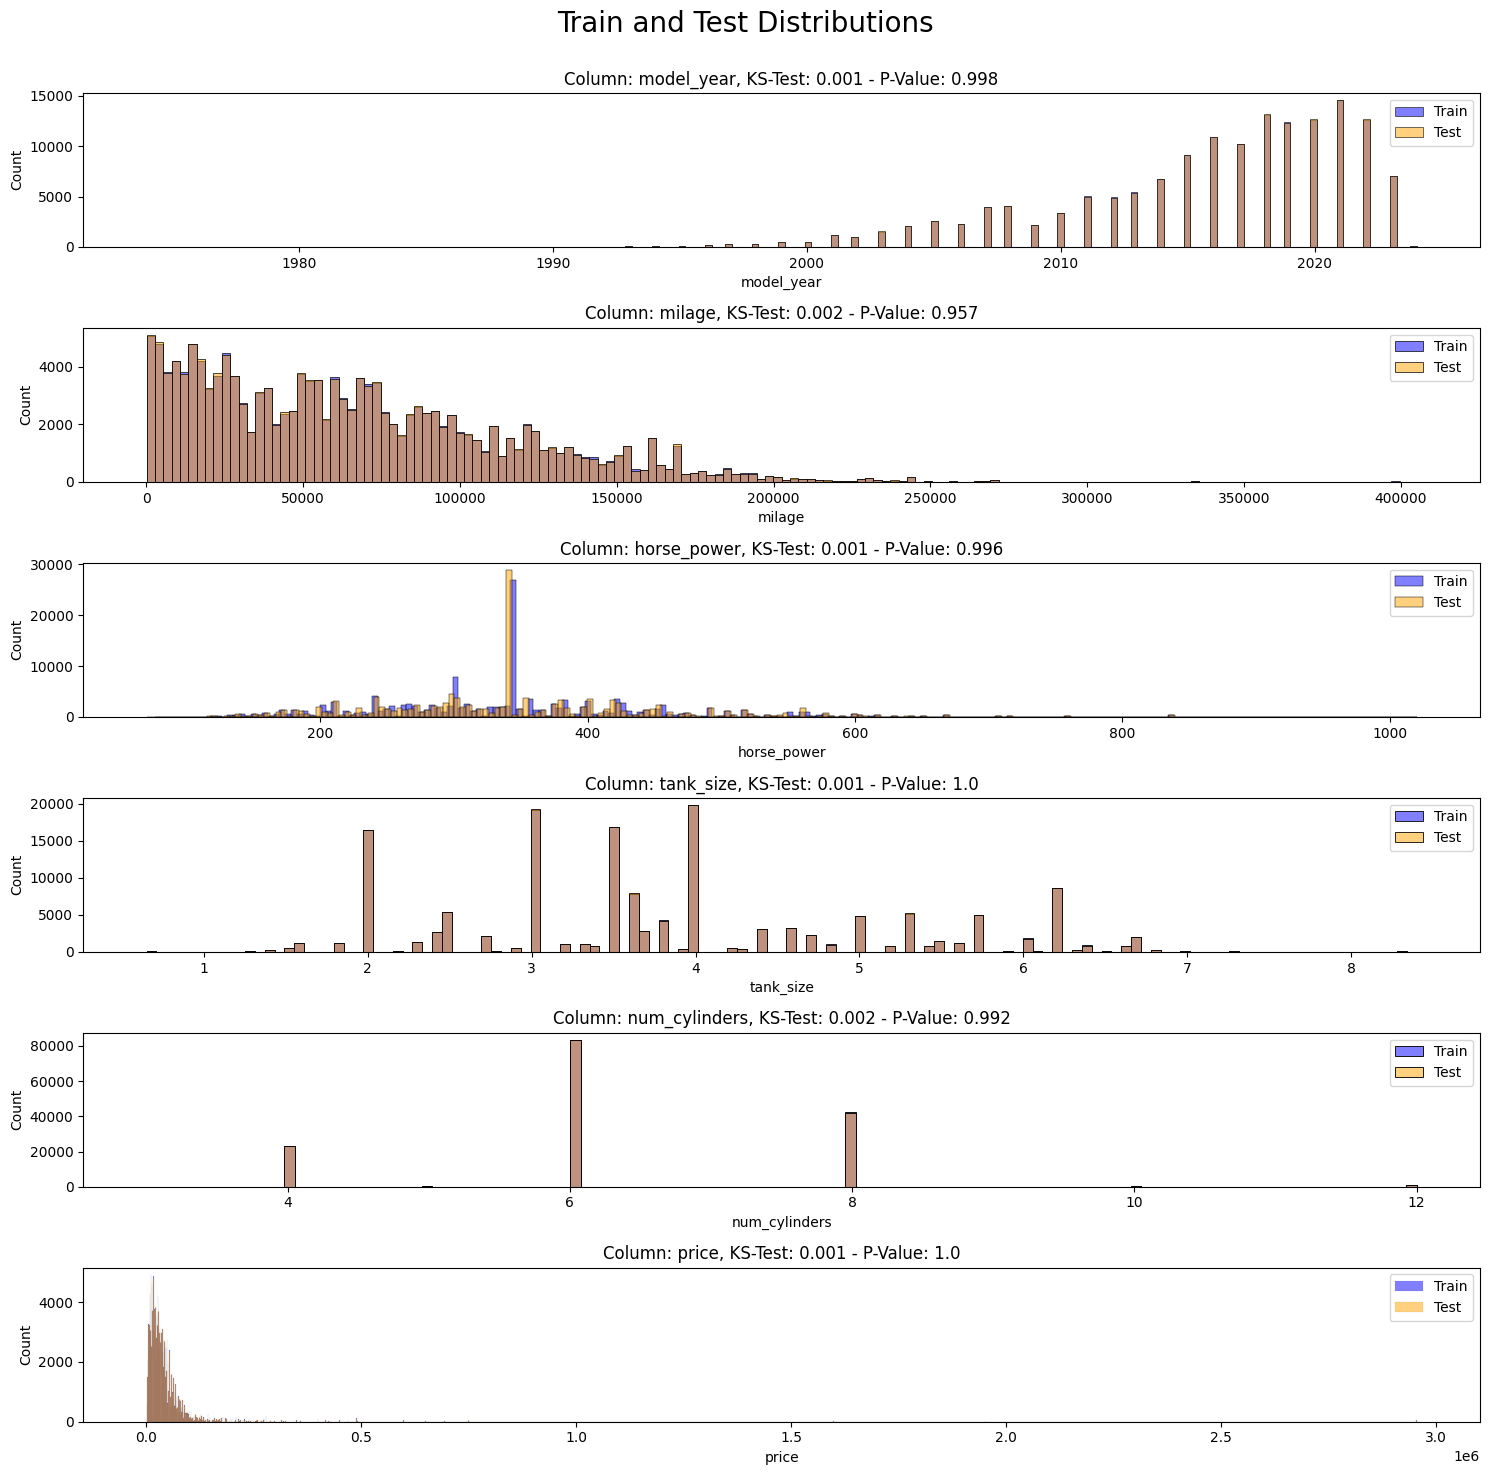

In [7]:
columns_to_hist = ['model_year', 'milage', 'horse_power', 'tank_size', 'num_cylinders', 'price']

fig, axes = plt.subplots(6, 1, figsize=(15, 15))
for i, column in enumerate(columns_to_hist):
    sns.histplot(df_train[column], ax=axes[i], color='blue', label='Train', alpha=0.5)
    sns.histplot(df_test[column], ax=axes[i], color='orange', label='Test', alpha=0.5)
    res,pval = ks_2samp(df_train[column],df_test[column])
    axes[i].set_title(f'Column: {column}, KS-Test: {round(res, 3)} - P-Value: {round(pval, 3)}')
    axes[i].legend()
fig.suptitle('Train and Test Distributions\n', fontsize=20)
plt.tight_layout()
plt.show()

## 1.1 Explainability changes

To improve the model explainability we would like to transform attributes differently than we did in the previous exercise.

Doing this would allow us to analyse the model errors better, as there would be less features that would clutter our view of the importance of each feature.

This is based on our first attempt at error analysis. We noticed how difficult it was for us to interpret the results from the SHAP graphs of the previous exercise.

In [101]:
org_df_train = pd.read_csv('../Part_1/data/raw_train_data.csv',index_col='id')
org_df_test = pd.read_csv('../Part_1/data/raw_test_data.csv',index_col='id')

### 1.1.1 Color

In the previous exercise we decided to discard of colors which were not of the top 12 most common colors.
This time we do not lose data by grouping defferent shades to their "origin" color.

In exchange we minimize the variety of our data column - under the premis that the differences in shade are not meaningful for the prediction of the car price.

In [102]:
colors_drop = [col for col in df_train if col.startswith(("int", "ext"))]

In [103]:
df_train = df_train.drop(columns=colors_drop)
df_test = df_test.drop(columns=colors_drop)

In [104]:
df_train = pd.concat([df_train,org_df_train[['int_col', 'ext_col']]],axis=1)
df_test = pd.concat([df_test,org_df_test[['int_col', 'ext_col']]],axis=1)

Colors that fall into "Other":

'oyster w/contrast', 'ceramic', 'gideon',
'sport', '–', 'designo magno matte',
'dark sapphire', 'custom color', 'tempest', 'lunar rock',
'nightfall mica', 'granite', 'Pink', 'c / c', 'yulong',
'go mango!', 'grigio nimbus', 'metallic'

In [105]:
def categorize_color(color):
    color = color.lower()
    # Black group
    if any(x in color for x in [
        'black', 'obsidian', 'raven', 'onyx', 'ebony', 'nero', 'blk',
        'graphite', 'charcoal', 'dark ash', 'anthracite', 'caviar', 
        'dark matter', 'magnetic', 'beluga', 'dark galvanized']):
        return 'Black'
    # White group
    elif any(x in color for x in [
        'white', 'pearl', 'ivory', 'frost', 'platinum', 'ice', 'cloud',
        'chalk', 'bianco', 'glacier', 'linen', 'very light cashmere', 
        'parchment', 'parchment.']):
        return 'White'
    # Blue group
    elif any(x in color for x in [
        'blue', 'navy', 'aqua', 'teal', 'stormy', 'blu', 'eleos']):
        return 'Blue'
    # Red group
    elif any(x in color for x in [
        'red', 'ruby', 'garnet', 'hotspur', 'pimento', 'rosso', 
        'scarlet', 'mars', 'corsa', 'chateau']):
        return 'Red'
    # Silver/Gray group
    elif any(x in color for x in [
        'silver', 'gray', 'grey', 'steel', 'medium pewter', 'slate', 
        'boulder', 'porpoise', 'light slate', 'tungsten', 'gun metallic', 
        'medium stone', 'portland', 'mesa', 'ash']):
        return 'Silver_Gray'
    # Green group
    elif any(x in color for x in [
        'green', 'verde', 'moss', 'deep cypress']):
        return 'Green'
    # Yellow/Orange group
    elif any(x in color for x in [
        'yellow', 'gold', 'orange', 'amber', 'arancio', 'hellayella', 
        'sunset drift', 'sandstone', 'tension']):
        return 'Yellow_Orange'
    # Brown group
    elif any(x in color for x in [
        'brown', 'beige', 'tan', 'mocha', 'brandy', 'chestnut', 
        'espresso', 'roast', 'dark auburn', 'aragon', 'bronze', 
        'dune', 'maroon', 'walnut', 'camel', 'caramel', 'macchiato', 
        'medium light camel', 'shale', 'cappuccino', 'tupelo']):
        return 'Brown'
    # Purple group
    elif any(x in color for x in ['purple', 'plum', 'ametrin', 'orchid', 'pink']):
        return 'Purple_Pink'
    # Default for unclassified entries
    else:
        return 'Other'

In [106]:
df_train['int_col'] = df_train['int_col'].apply(categorize_color)
df_train['ext_col'] = df_train['ext_col'].apply(categorize_color)

df_test['int_col'] = df_test['int_col'].apply(categorize_color)
df_test['ext_col'] = df_test['ext_col'].apply(categorize_color)

Converting the new int_color, ext_color to One-Hot features for the Linear Regression model.

We combine train and test data to ensure consistent encoding.

In [107]:
df_combined = pd.concat([df_train, df_test])

# Convert categorical columns to numeric using one-hot encoding
df_combined = pd.get_dummies(df_combined, columns=['int_col', 'ext_col'], drop_first=True)

# boolean_columns = df_combined.select_dtypes(include=['bool']).columns
# df_combined[boolean_columns] = df_combined[boolean_columns].astype(int)

# Split the combined data back into train and test sets
df_train = df_combined.iloc[:len(df_train)]
df_test = df_combined.iloc[len(df_train):]

In [108]:
df_train.head()

,model_year,milage,accident,clean_title,horse_power,tank_size,num_cylinders,automatic,manual,dual,...,int_col_Yellow_Orange,ext_col_Blue,ext_col_Brown,ext_col_Green,ext_col_Other,ext_col_Purple_Pink,ext_col_Red,ext_col_Silver_Gray,ext_col_White,ext_col_Yellow_Orange
id,,,,,,,,,,,,,,,,,,,,,
0,2007,213000,False,True,172.0,1.6,4.0,True,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2002,143250,True,True,252.0,3.9,8.0,True,False,False,...,False,False,False,False,False,False,False,True,False,False
2,2002,136731,False,True,320.0,5.3,8.0,True,False,False,...,False,True,False,False,False,False,False,False,False,False
3,2017,19500,False,True,420.0,5.0,8.0,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,2021,7388,False,True,208.0,2.0,4.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False


## Testing the changes

We can see that the transformation of the color columns had almost no affect on the R2 score, meaning our previous thing did not do good.

In [109]:
print(f'R2 Score before convering the color columns: {round(0.10637623834770804, 4)}')

score_after_change = train_score_model(df_train, df_test)
print(f'R2 Score after convering the color columns: {round(score_after_change, 4)}')

R2 Score before convering the color columns: 0.1064
R2 Score after convering the color columns: 0.1057


### 1.1.2 Horse power 

In [15]:
df_train_transformed = pd.read_csv('../Part_1/data/transformed_train_data.csv',index_col='id')
df_test_transformed = pd.read_csv('../Part_1/data/transformed_test_data.csv',index_col='id')

Replacing the data for Not Supported, Nan and - in fuel type to random values and checking if it changes the r squared

In [16]:
# Capture the original column order of df_train and df_test
original_train_columns = df_train.columns
original_test_columns = df_test.columns

min_hp = df_train['horse_power'].min()
max_hp = df_train['horse_power'].max()

# Check the value of 'horse_power' in the original dataframe and update the one-hot encoded columns in df
def replace_invalid_horse_power(row, org_row):
    if pd.isna(org_row['horse_power']):
        new_horse_power = np.random.randint(min_hp, max_hp)
        row['horse_power'] = new_horse_power
    return row

# Apply the function to the 'horse_power' column in both train and test dataframes
df_train = df_train.apply(lambda row: replace_invalid_horse_power(row, df_train_transformed.loc[row.name]), axis=1)
df_test = df_test.apply(lambda row: replace_invalid_horse_power(row, df_test_transformed.loc[row.name]), axis=1)

# Restore the original column order
df_train = df_train[original_train_columns]
df_test = df_test[original_test_columns]

KeyboardInterrupt: 

In [19]:
print(f'R2 Score before replacing fuel type values with random values: {round(score_after_change, 4)}')

score_after_change_ = train_score_model(df_train, df_test)
print(f'R2 Score after replacing fuel type values with random value: {round(score_after_change_, 4)}')

R2 Score before replacing fuel type values with random values: 0.1057
R2 Score after replacing fuel type values with random value: 0.1049


As we can see, we got about the same R^2 value even with random values imputation. Therefore, we can infer that we need to come up with another way to fill those values. Maybe using KNN.

In [20]:
from sklearn.impute import KNNImputer

df_train_transformed_copy = df_train_transformed.copy()
df_test_transformed_copy = df_test_transformed.copy()

# Apply KNNImputer
imputer = KNNImputer(n_neighbors=3)

# Impute missing values in 'horse_power' for df_train_transformed_copy and df_test_transformed_copy
df_train_transformed_copy['horse_power'] = imputer.fit_transform(df_train_transformed_copy[['horse_power']])
df_test_transformed_copy['horse_power'] = imputer.transform(df_test_transformed_copy[['horse_power']])
 
# Update the one-hot encoded columns in df_train using the imputed 'horse_power' values from org_df_train_copy
def update_horse_power_encoding(row, imputed_horse_power):
    row['horse_power'] = imputed_horse_power
    return row

# Apply the updates to df_train and df_test
df_train = df_train.apply(lambda row: update_horse_power_encoding(row, df_train_transformed_copy.loc[row.name, 'horse_power']), axis=1)
df_test = df_test.apply(lambda row: update_horse_power_encoding(row, df_test_transformed_copy.loc[row.name, 'horse_power']), axis=1)


In [21]:
print(f'R2 Score before replacing fuel type values with KNN-based values: {round(score_after_change, 4)}')

score_after_change = train_score_model(df_train, df_test)
print(f'R2 Score after replacing fuel type values with KNN-based value: {round(score_after_change, 4)}')

R2 Score before replacing fuel type values with KNN-based values: 0.1057
R2 Score after replacing fuel type values with KNN-based value: 0.1057


Didn't see a change, probably because there were only 3% of the data. let's do it on a different attribute (maybe horsepower)

### 1.1.3 Brand

In exercise 1 we decided to turn brands into One-Hot vectors. Since there are many brands, we decided to turn only the 24 most common brand names into binary features, lumping the rest as "Other"

Since the mass of features this raises interfears with our understanding on the model error's, we would like to encode the brand names in a way that does not inflate the data's dimention.

Ordinal encoding does not fir because there is no order to the brands. 

We decided to use Target Encoding for this cause.

In [110]:
org_df_train.brand

id
0                  MINI
1               Lincoln
2             Chevrolet
3               Genesis
4         Mercedes-Benz
              ...      
150821             Audi
150822            Honda
150823         Cadillac
150824          Ferrari
150825             Ford
Name: brand, Length: 150826, dtype: object

In [111]:
# Restoring the original cbrand column and removing the ones created by one-hot encoding

cols_to_drop = [col for col in df_train.columns if col.startswith('brand')]
df_train = df_train.drop(columns=cols_to_drop)
cols_to_drop = [col for col in df_test.columns if col.startswith('brand')]
df_test = df_test.drop(columns=cols_to_drop)
df_train['brand'] = org_df_train['brand']
df_test['brand'] = org_df_test['brand']


In [112]:
import category_encoders as ce

# Apply target encoding to the 'brands' feature
target_encoder = ce.TargetEncoder(cols=['brand'])

df_train['brand'] = target_encoder.fit_transform(df_train['brand'], df_train['price'])
df_test['brand'] = target_encoder.transform(df_test['brand'])


In [113]:
print(f'R2 Score before target encoding the brands: {round(score_after_change, 4)}')

score_after_change = train_score_model(df_train, df_test)
print(f'R2 Score after target encoding the brands: {round(score_after_change, 4)}')

R2 Score before target encoding the brands: 0.1057
R2 Score after target encoding the brands: 0.1108


We can see that the model's R2 score sligtly increased. Since we managed to deflate the number of features by that, it is a good change.

In [114]:
# How the brand column looks like after target encoding

df_train['brand'][0:8]

id
0    17474.865362
1    30254.776847
2    42160.109066
3    54883.714834
4    51422.492446
5    41027.750919
6    41027.750919
7    42160.109066
Name: brand, dtype: float64

## 1.2 Data and model changes

Brand transformation - Arbel ✔

remove outlliers && divide the price range into bins, check if there is an equal number of data entries for each price bin. maybe balance if not. Yael

multiple collinearity show features correlation to one another [df.corr()] - decide on a course of action - Arbel

rescale features which are not in a linear relationship with the price - Yael

turn n values into n-1 One-Hot features: trasmission (baseline should be the most frequent value) - Arbel

### 1.2.1 Filling Transmission missing values

In [115]:
no_transmission = df_train[(df_train['automatic'] == 0) & (df_train['manual'] == 0) & (df_train['dual'] == 0)]
no_transmission.shape[0]

443

In [116]:
for idx in no_transmission.index[:3]:
    print(f'Index: {idx}, Transmission: {org_df_train["transmission"][idx]}')
for idx in no_transmission.index[7:15]:
    print(f'Index: {idx}, Transmission: {org_df_train["transmission"][idx]}')

Index: 458, Transmission: Transmission Overdrive Switch
Index: 931, Transmission: F
Index: 1539, Transmission: –
Index: 2679, Transmission: F
Index: 3037, Transmission: Transmission Overdrive Switch
Index: 3038, Transmission: 2
Index: 3293, Transmission: 7-Speed
Index: 3585, Transmission: Variable
Index: 3630, Transmission: Transmission Overdrive Switch
Index: 4520, Transmission: Single-Speed Fixed Gear
Index: 5642, Transmission: 2


Our domain knowledge suggests that there cannot be a car with a trasmission type which is not 'manual', 'automatic' or 'dual', so regardless of whether the transmission attribute was mislabeled or missing, we will fill it with a value.

We do it like before, using the KNN imputer.

<Axes: >

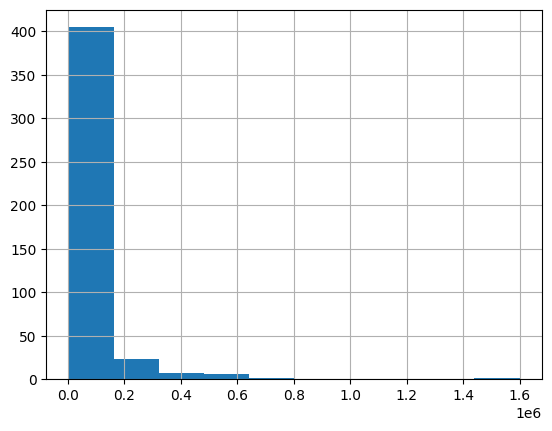

In [117]:
no_transmission['price'].hist()

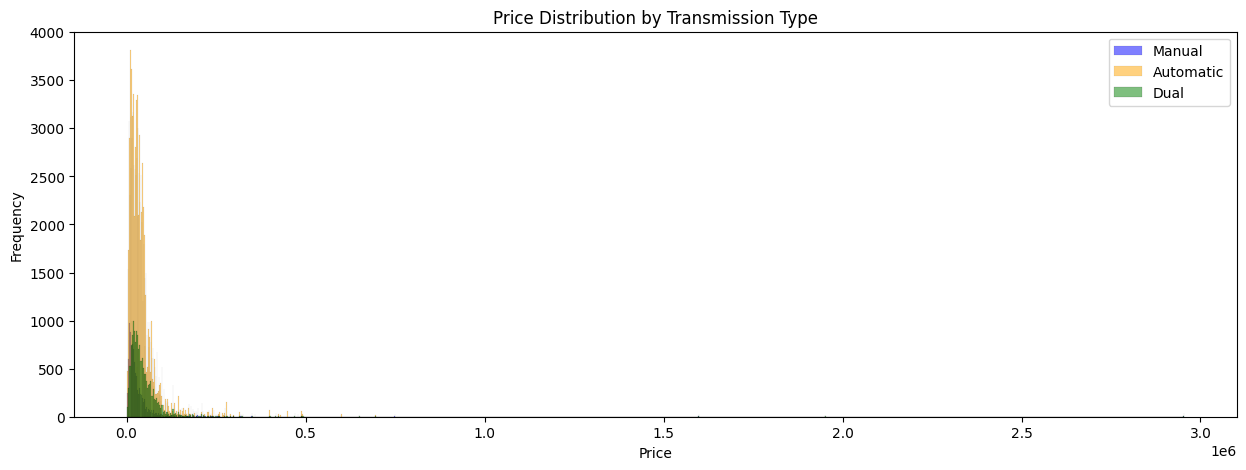

In [66]:
plt.figure(figsize=(15, 5))
sns.histplot(df_train[df_train['manual'] == 1]['price'], color='blue', label='Manual', alpha=0.5)
sns.histplot(df_train[df_train['automatic'] == 1]['price'], color='orange', label='Automatic', alpha=0.5)
sns.histplot(df_train[df_train['dual'] == 1]['price'], color='green', label='Dual', alpha=0.5)
plt.legend()
plt.title('Price Distribution by Transmission Type')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [118]:
# Automatic transmission is by far the most common type in the dataset, so we will set the 'no_transmission' rows to 'automatic'

df_train.loc[(df_train['automatic'] == 0) & (df_train['manual'] == 0) & (df_train['dual'] == 0), 'automatic'] = True
df_test.loc[(df_test['automatic'] == 0) & (df_test['manual'] == 0) & (df_test['dual'] == 0), 'automatic'] = True

In [119]:
no_transmission_after_fill = df_train[(df_train['automatic'] == 0) & (df_train['manual'] == 0) & (df_train['dual'] == 0)]
no_transmission_after_fill.shape[0]

0

### 1.2.2 One-Hot n-1 columns transformation

We learned in classs that it is mathematically adventageous to encode an attribute of n unique values with n-1 columns.

This results with a base category that we assume a sample has, if it is marked 'False' for all other one-hot attributes. This base category should be the most frequent value of the original attribute, in our case we saw that it is 'Automatic'.

In [120]:
df_train = df_train.drop(columns=['automatic'])
df_test = df_test.drop(columns=['automatic'])

In [121]:
print(f'R2 Score before filling transmission nulls and dropiing the most frequent One-Hot attribute: {round(score_after_change, 4)}')

score_after_change = train_score_model(df_train, df_test)
print(f'R2 Score after filling transmission nulls and dropiing the most frequent One-Hot attribute: {round(score_after_change, 4)}')

R2 Score before filling transmission nulls and dropiing the most frequent One-Hot attribute: 0.1108
R2 Score after filling transmission nulls and dropiing the most frequent One-Hot attribute: 0.1107


We can see the effect was not significant, probably due to the fact that hte number of nulls was very low (443/15000), and that this transformation was not that meaningful to start with.